In [1]:
import urllib.request
import numpy as np
import os
from PIL import Image
import requests
import matplotlib.pyplot as plt
from PIL import ImageOps
klasor={
"airplane":["airplane"],
"automobile": ["car","police car"],
"bird": ["bird","duck","flamingo","owl","parrot","penguin","swan"],
"cat":["cat","lion","tiger"],
"dog":["dog"],
"frog":["frog"],
"horse":["horse"],
"ship": ["cruise ship","sailboat","speedboat"],
"truck":["truck","firetruck"]
}

adet=2100

def resimYaz(resim,yol,resim_ad):    
    sayi=1
    print(yol)
    for ary in resim:
      img = Image.fromarray(ary)
      img = ImageOps.invert(img)
      if img.size != (79,79 ):
        img = img.resize((79,79),resample=Image.LANCZOS)
      metin =yol+"/"+resim_ad+str(sayi)+".png"
      img.save(metin)
      sayi+=1

for key,value in klasor.items():
    kategori_sayi=len(value)
    sayi=adet/kategori_sayi
    print(sayi)
    for item in value:
        kategori_adi = item.replace(" ", "%20")
        url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"+kategori_adi+".npy" # url hazırlandı
        
        dosya_adi = "a.npy" # indirilen dosyanın adı
        urllib.request.urlretrieve(url, dosya_adi)

        data = np.load(dosya_adi)  # npy dosyasını yükleme
        data = data.reshape(data.shape[0], 28, 28)  # 28x28 boyutunda yeniden boyutlandırma
        data = data.astype('uint8')  # veri tipini uint8 olarak ayarlama

        resimler = data[:int(sayi)] # dosyadaki ilk adet kadar resmi seç
        kayıt_yol="quickdraw_dataset/"+str(key)+"/"+str(item) # resimler için klasor oluşturma
        if not os.path.exists(kayıt_yol):
          os.makedirs(kayıt_yol)

        resimYaz(resimler,kayıt_yol,item) # resimleri png formata çevirme
        
        os.remove(dosya_adi) # indirilen dosyayı dosyayı silme


2100.0

quickdraw_dataset/airplane/airplane

1050.0

quickdraw_dataset/automobile/car

quickdraw_dataset/automobile/police car

300.0

quickdraw_dataset/bird/bird

quickdraw_dataset/bird/duck

quickdraw_dataset/bird/flamingo

quickdraw_dataset/bird/owl

quickdraw_dataset/bird/parrot

quickdraw_dataset/bird/penguin

quickdraw_dataset/bird/swan

700.0

quickdraw_dataset/cat/cat

quickdraw_dataset/cat/lion

quickdraw_dataset/cat/tiger

2100.0

quickdraw_dataset/dog/dog

2100.0

quickdraw_dataset/frog/frog

2100.0

quickdraw_dataset/horse/horse

700.0

quickdraw_dataset/ship/cruise ship

quickdraw_dataset/ship/sailboat

quickdraw_dataset/ship/speedboat

1050.0

quickdraw_dataset/truck/truck

quickdraw_dataset/truck/firetruck


In [2]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 10.7 MB/s eta 0:00:00












In [3]:

import tensorflow as tf
import os
from tensorflow.keras import Model,models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Dropout,BatchNormalization,Conv2D,Flatten,MaxPool2D,Concatenate,AveragePooling2D

from tensorflow.keras.preprocessing.image import img_to_array, load_img

from tensorflow.keras.optimizers import Adam,SGD,RMSprop

import kerastuner
from kerastuner.tuners import Hyperband

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import sklearn
import itertools
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

np.set_printoptions(precision=3, suppress=True)

<ipython-input-3-83dc497d5ef7>:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.

  import kerastuner


In [4]:
dosya_yol = os.path.join('quickdraw_dataset')
classes=["airplane","automobile","bird","cat","dog","frog","horse","ship","truck"]

batch_size=32
img_size=(79,79)

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(dosya_yol,
                                                          class_names=classes,
                                                          labels="inferred",
                                                          label_mode="categorical",
                                                                 
                                                          batch_size=batch_size,
                                           
                                                          image_size=img_size,
                                                          color_mode='grayscale',       
                                                          seed=123,
                                                          )



Found 18900 files belonging to 9 classes.


In [6]:
# shuffle edilmiş veri setinin oluşturulması
train_data = dataset.shuffle(buffer_size=len(dataset), seed=123, reshuffle_each_iteration=False)

tum = tf.data.experimental.cardinality(train_data)
test_data = train_data.take(tum // 5)
train_data = train_data.skip(tum // 5)

train_data = train_data.shuffle(buffer_size=len(train_data), seed=123, reshuffle_each_iteration=False)
train_toplam = tf.data.experimental.cardinality(train_data)
val_data = train_data.take(train_toplam // 5)
train_data = train_data.skip(train_toplam // 5)

print('Number of train batches: %d' % tf.data.experimental.cardinality(train_data))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_data))
print('Number of val batches: %d' % tf.data.experimental.cardinality(val_data))

Number of train batches: 379

Number of test batches: 118

Number of val batches: 94


from tensorflow.keras import layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(height_factor=(-0.3,0.3), width_factor=(-0.3,0.3),fill_mode="constant", fill_value=255), # rastgele yakınlaştırma
    layers.RandomRotation(factor=0.2,fill_mode="constant", fill_value=255), # rastgele döndürme
    layers.RandomTranslation(height_factor=(-0.1,0.1), width_factor=(-0.1,0.1),fill_mode="constant", fill_value=255), # rastgele kaydırma
])

img_path = "/kaggle/input/denemecizimler/araba2.png"
# Resmi yükle ve boyutlandır
img = Image.open(img_path).convert('L')
img = img.resize((img_size), resample=Image.LANCZOS)
# Resmi model için hazırla
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
print(x.shape)
plt.figure(figsize=(3, 3))
for i in range(9):
  augmented_image = data_augmentation(x)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0],cmap='gray')
  plt.axis("off")
augmented_image[0].shape    
#conv2d çıktı hesaplama
#Çıkış Boyutu = (Girdi Boyutu - kernelsize )+ 1

data=train_data
for i in range(3):
    #Train dataya data augmentation modelini uygula
    train_data_augmented = train_data.map(lambda x, y: (data_augmentation(x, training=True), y))
    data=data.concatenate(train_data_augmented)
# Train ve augmented veri setlerini birleştir
train_data = data.shuffle(buffer_size=len(data), seed=4, reshuffle_each_iteration=False)
num_train_data = tf.data.experimental.cardinality(train_data).numpy()
print("Number of training batch examples:", num_train_data)

In [7]:
train_data = train_data.shuffle(buffer_size=len(train_data), seed=7, reshuffle_each_iteration=False)
Xtrain = []
Ytrain = []
for image, label in train_data: 
    Xtrain.append(image)
    Ytrain.append(label)
Xtrain= np.concatenate(Xtrain)
Ytrain = np.concatenate(Ytrain)
# Veri sayısını yazdırma
train_veri_sayisi = len(Xtrain)
print("train veri sayısı:", train_veri_sayisi)

val_data = val_data.shuffle(buffer_size=len(val_data), seed=7, reshuffle_each_iteration=False)
Xval = []
Yval = []
for image, label in val_data: 
    Xval.append(image)
    Yval.append(label)
Xval= np.concatenate(Xval)
Yval = np.concatenate(Yval)
# Veri sayısını yazdırma
train_veri_sayisi = len(Xval)
print("val veri sayısı:", train_veri_sayisi)

train veri sayısı: 12116

val veri sayısı: 3008


In [8]:
img_shape =img_size + (1,)
from tensorflow.keras import regularizers

def create_model(optimizer,learning_rate,droprate,kernel_size,filters,activation,units):
    
    input_img = Input(shape=img_shape) 
    conv1 =Conv2D(filters=filters,kernel_size=kernel_size,activation=activation,name='conv1')(input_img) 
    pool1 =AveragePooling2D(name='pool1')(conv1)
    drop1 =Dropout(droprate,name='drop1')(pool1) 
    
    conv2 =Conv2D(filters=filters*2,kernel_size=kernel_size,activation=activation,name='conv2')(drop1)
    pool2 =AveragePooling2D(name='pool2')(conv2)
    drop2 =Dropout(droprate,name='drop2')(pool2)
    
    conv3 =Conv2D(filters=filters*4,kernel_size=kernel_size,activation=activation,name='conv3')(drop2)
    pool3 =AveragePooling2D(name='pool3')(conv3)
    drop3 =Dropout(droprate,name='drop3')(pool3)
    
    conv4 =Conv2D(filters=filters*8,kernel_size=kernel_size,activation=activation,name='conv4')(drop3)
    pool4=AveragePooling2D(name='pool4')(conv4)
    drop4 =Dropout(droprate,name='drop4')(pool4)
    
        
    flatten = Flatten(name='flatten')(drop4)
    
    dense1 = Dense(units,activation=activation,name='dense1')(flatten)
    drop5  = Dropout(droprate,name='drop5')(dense1)    
    dense2 = Dense(units/2,activation=activation,name='dense2')(drop5)
    drop6  = Dropout(droprate,name='drop6')(dense2)
    dense3 = Dense(units/4,activation=activation,name='dense3')(drop6)
   
    output=Dense(len(classes),activation='softmax',name='output')(dense3)
    
    model = Model(inputs=input_img, outputs=output)
    
    if optimizer == 'Adam': optimizer = Adam
    elif optimizer=='SGD': optimizer=SGD
    else: optimizer = RMSprop
        
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer(learning_rate=learning_rate),metrics=['accuracy'])
    
    return model

# Fonksiyon, modeli hiperparametre setiyle eğitir
def train_model(hp):
    
    optimizer = hp.Choice('optimizer', ['Adam', 'RMSprop','SGD'])
    learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    droprate=hp.Choice('droprate', values=[0.2,0.3,0.4,0.5,0.6])
    kernel_size=hp.Int('kernel_size',3,5,step=1)
    filters=hp.Choice('filters',values=[8,16,32,64,128])
    activation=hp.Choice('activation',values=['relu','elu','softmax','tanh','sigmoid'])
    units=hp.Choice('units',values=[64,128,256,512])

    model = create_model(optimizer,learning_rate,droprate,kernel_size,filters,activation,units) 
    return model

In [9]:
hyperband = Hyperband(train_model, objective='val_loss', max_epochs=50,seed=2, factor=3)
stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
hyperband.search(Xtrain,Ytrain,validation_data=(Xval,Yval),callbacks=[stopping,reduce_lr])

Trial 90 Complete [00h 01m 59s]

val_loss: 2.1972057819366455



Best val_loss So Far: 0.2989971339702606

Total elapsed time: 02h 22m 28s


In [10]:
best_hyperparameters = hyperband.get_best_hyperparameters(1)[0]

optimizer = best_hyperparameters.get('optimizer')
learning_rate = best_hyperparameters.get('learning_rate')

units=best_hyperparameters.get('units')
droprate=best_hyperparameters.get('droprate')

kernel_size=best_hyperparameters.get('kernel_size')
filters=best_hyperparameters.get('filters')
activation=best_hyperparameters.get('activation')

print("Best optimizer:", optimizer)
print("Best learning rate:", learning_rate)
print("Best units:", units)
print("Best  droprate:", droprate)
print("Best kernel_size:", kernel_size)
print("Best filters:", filters)
print("Best activation:", activation)


Best optimizer: Adam

Best learning rate: 0.001

Best units: 512

Best  droprate: 0.3

Best kernel_size: 4

Best filters: 32

Best activation: elu


In [11]:
best_model = train_model(best_hyperparameters)
best_model.summary()

Model: "model_1"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 79, 79, 1)]       0         

                                                                 

 conv1 (Conv2D)              (None, 76, 76, 32)        544       

                                                                 

 pool1 (AveragePooling2D)    (None, 38, 38, 32)        0         

                                                                 

 drop1 (Dropout)             (None, 38, 38, 32)        0         

                                                                 

 conv2 (Conv2D)              (None, 35, 35, 64)        32832     

                                                                 

 pool2 (AveragePooling2D)    (None, 17, 17, 64)        0         

                                                                 

 drop2 (Dropout)             (None, 17, 17,

In [12]:
all_train_loss = []
all_train_acc = []
all_val_loss = []
all_val_acc = []
acc_scores = []  
k = 3
from sklearn.metrics import accuracy_score
kf = KFold(n_splits = k,shuffle=True,random_state=1)
stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
#K-folf cross-validation 
for train_index, test_index in kf.split(Xtrain):
  #test train diye ayır
  X_train, X_test = Xtrain[train_index], Xtrain[test_index]
  y_train, y_test = Ytrain[train_index], Ytrain[test_index]
  
  #Modeli eğitme
  egit=best_model.fit(X_train,y_train,validation_data=(Xval,Yval),shuffle=True,epochs=200,batch_size=32,callbacks=[stopping,reduce_lr])
  print('------------------------------------------------------------------------------------------------------------------------------------')
  # Eğitim ve validation loss/accuracy değerlerini kaydedin
  all_train_loss.append(egit.history['loss'])
  all_train_acc.append(egit.history['accuracy'])
  all_val_loss.append(egit.history['val_loss'])
  all_val_acc.append(egit.history['val_accuracy'])
    
  # Predicting values for the testing dataset  
  Y_pred = best_model.predict(X_test)  
  Y_pred = np.argmax(Y_pred, axis=1) 
  y_test = tf.concat(y_test, axis=1)
  y_test = np.argmax(y_test, axis=1)
  # Calculatinf accuracy score using in-built sklearn accuracy_score method   
  acc = accuracy_score(Y_pred , y_test)  
  acc_scores.append(acc)  
      
# Calculating mean accuracy score  
mean_acc_score = sum(acc_scores) / k  
print("Accuracy score of each fold: ", acc_scores)  
print("Mean accuracy score: ", mean_acc_score)  

Epoch 1/200

253/253 [==============================] - 7s 18ms/step - loss: 2.0929 - accuracy: 0.3457 - val_loss: 1.0811 - val_accuracy: 0.6320 - lr: 0.0010

Epoch 2/200

253/253 [==============================] - 4s 14ms/step - loss: 1.2461 - accuracy: 0.5590 - val_loss: 0.9747 - val_accuracy: 0.6765 - lr: 0.0010

Epoch 3/200

253/253 [==============================] - 4s 14ms/step - loss: 1.0730 - accuracy: 0.6307 - val_loss: 0.8330 - val_accuracy: 0.7055 - lr: 0.0010

Epoch 4/200

253/253 [==============================] - 4s 15ms/step - loss: 0.9407 - accuracy: 0.6697 - val_loss: 0.8628 - val_accuracy: 0.6988 - lr: 0.0010

Epoch 5/200

253/253 [==============================] - 4s 14ms/step - loss: 0.8687 - accuracy: 0.6943 - val_loss: 0.7058 - val_accuracy: 0.7583 - lr: 0.0010

Epoch 6/200

253/253 [==============================] - 4s 17ms/step - loss: 0.8067 - accuracy: 0.7190 - val_loss: 0.7139 - val_accuracy: 0.7566 - lr: 0.0010

Epoch 7/200

253/253 [========================

In [13]:
all_train_acc= np.concatenate(all_train_acc)
all_val_acc= np.concatenate(all_val_acc)
all_train_loss= np.concatenate(all_train_loss)
all_val_loss= np.concatenate(all_val_loss)

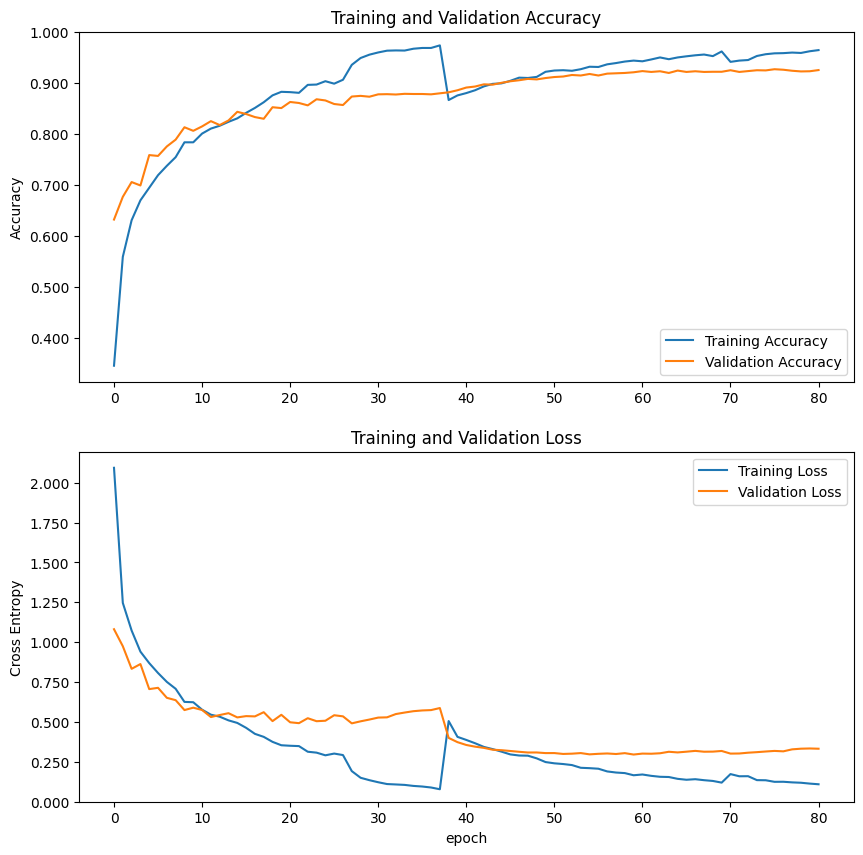

In [14]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(all_train_acc, label='Training Accuracy')
plt.plot(all_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.gca().yaxis.set_major_formatter('{:.3f}'.format) # burada y-ekseninin etiketleri için 3 basamaklı virgülden sonra yuvarlama yapıyoruz
plt.ylim([min(plt.ylim()),1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(all_train_loss, label='Training Loss')
plt.plot(all_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.gca().yaxis.set_major_formatter('{:.3f}'.format) # burada y-ekseninin etiketleri için 3 basamaklı virgülden sonra yuvarlama


In [15]:
import datetime
# tarih ve saat bilgisini al
now = datetime.datetime.now()
# kaydedilecek dosyanın adını oluştur
file_name = f"model_{now.strftime('%Y%m%d_%H%M%S')}.h5"
# modeli kaydet
best_model.save(file_name)

In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()
with open("model_"+now.strftime('%Y%m%d_%H%M%S')+'.tflite', 'wb') as f:
    f.write(tflite_model)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/







     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 30.1 MB/s eta 0:00:00




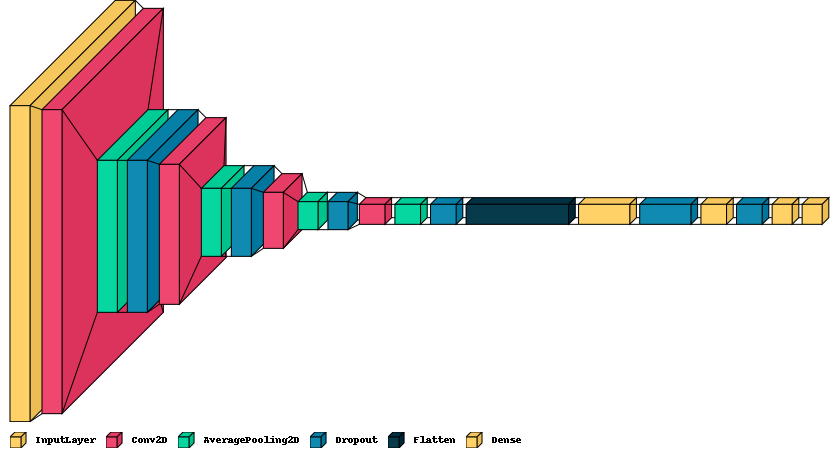

In [17]:
!pip install visualkeras
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(best_model, legend=True)   

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1/1 [==============================] - 0s 158ms/step

conv1

(1, 38, 38, 64)

conv2

(1, 18, 18, 128)

conv3

(1, 8, 8, 256)

conv4

(1, 3, 3, 512)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


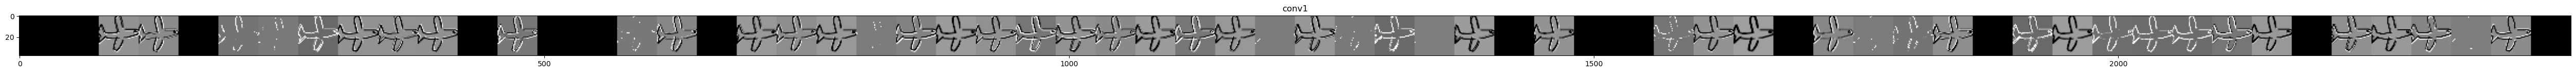

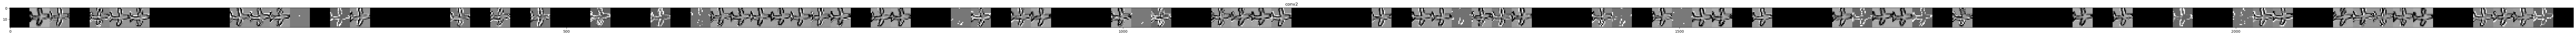

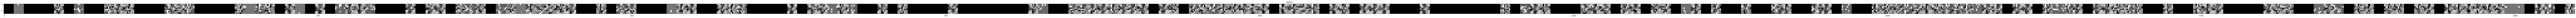

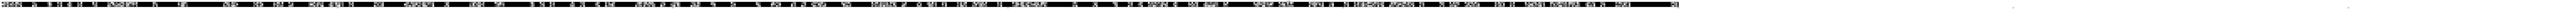

In [ ]:
img_path='/kaggle/input/ucak-tek-resim/airplane164.png' #ucak
successive_outputs = [layer.output for layer in best_model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = best_model.input, outputs = successive_outputs)
#Load the input image
img = Image.open(img_path).convert('L')
img = img.resize((img_size))
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)
successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in visualization_model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if 'conv' in layer_name:
    print(layer_name)
    print(feature_map.shape)
    if len(feature_map.shape) == 4:
     n_features = feature_map.shape[-1]  # number of features in the feature map
     size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
     # We will tile our images in this matrix
     display_grid = np.zeros((size, size * n_features))
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x  
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.gcf().set_size_inches(n_features,1)
    plt.imshow( display_grid, aspect='auto', cmap='gray' )
    
  

In [23]:
Xtest = []
Ytest= []
for image, label in test_data: 
    Xtest.append(image)
    Ytest.append(label)
Xtest = np.concatenate(Xtest)
Ytest = np.concatenate(Ytest)
# Veri sayısını yazdırma
test_veri_sayisi = len(Xtest)
print("Test veri sayısı:", test_veri_sayisi)

Test veri sayısı: 3776


In [24]:
#Xtest /=255
#test işlemi ön hazırlık
test_pred_raw = best_model.predict(Xtest)
#print(test_pred_raw)

test_pred = np.argmax(test_pred_raw, axis=1)
#print(test_pred)
print('----------------------------')
test_target = tf.concat(Ytest, axis=1)
#print(test_target)
test_target = np.argmax(test_target, axis=1)
#print(test_target)

118/118 [==============================] - 1s 9ms/step

----------------------------


In [25]:
print(classification_report(test_target,test_pred, target_names=classes,digits=3))

              precision    recall  f1-score   support



    airplane      0.970     0.974     0.972       429

  automobile      0.965     0.915     0.939       387

        bird      0.937     0.894     0.915       435

         cat      0.896     0.911     0.903       405

         dog      0.858     0.882     0.870       424

        frog      0.881     0.913     0.897       404

       horse      0.952     0.941     0.946       423

        ship      0.968     0.966     0.967       443

       truck      0.929     0.951     0.940       426



    accuracy                          0.928      3776

   macro avg      0.928     0.928     0.928      3776

weighted avg      0.929     0.928     0.928      3776




In [30]:
#Karmaşıklı matrisi
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.
  Args: ,
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(7, 7))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Compute the labels from the normalized confusion matrix.
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "yellow" if cm[i, j] > threshold else "blue"
    plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  
  return figure

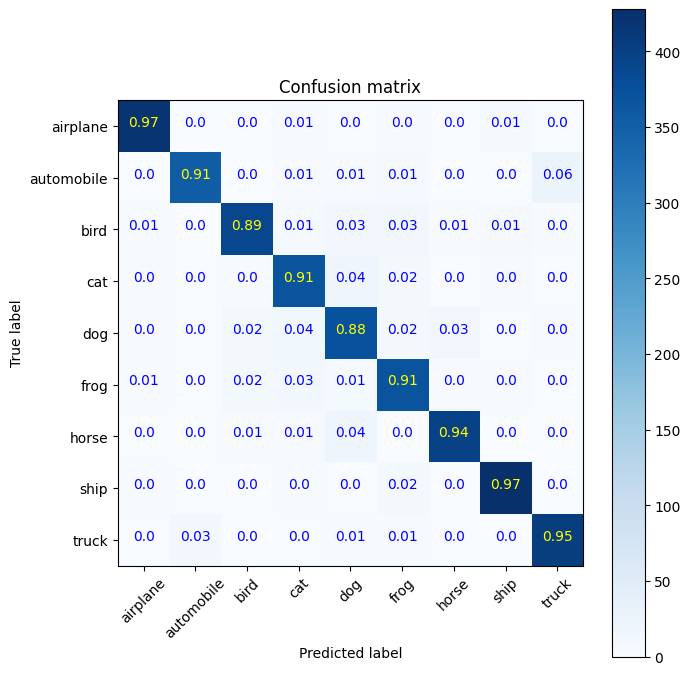

In [27]:
#confusion matrix hesaplama
cm = sklearn.metrics.confusion_matrix(test_target, test_pred)
# sonuçları confusion matrix i görselleştirme 
figure = plot_confusion_matrix(cm, class_names=classes)

1/1 [==============================] - 0s 22ms/step

[[0.    0.    0.998 0.    0.001 0.    0.    0.    0.   ]]

Resim: bird1.png Tahmin: 2

1/1 [==============================] - 0s 22ms/step

[[0. 0. 0. 0. 0. 1. 0. 0. 0.]]

Resim: frog5.png Tahmin: 5

1/1 [==============================] - 0s 21ms/step

[[0.016 0.001 0.104 0.03  0.158 0.062 0.623 0.001 0.005]]

Resim: at1.png Tahmin: 6

1/1 [==============================] - 0s 22ms/step

[[0.    0.588 0.    0.    0.    0.382 0.    0.019 0.01 ]]

Resim: araba2.png Tahmin: 1

1/1 [==============================] - 0s 22ms/step

[[0.05  0.046 0.08  0.06  0.082 0.312 0.011 0.331 0.028]]

Resim: gemi2.png Tahmin: 7

1/1 [==============================] - 0s 20ms/step

[[0.215 0.088 0.141 0.063 0.031 0.155 0.082 0.133 0.092]]

Resim: ucak2.png Tahmin: 0

1/1 [==============================] - 0s 20ms/step

[[0.001 0.    0.019 0.002 0.007 0.969 0.001 0.    0.   ]]

Resim: kurbaga1png.png Tahmin: 5

1/1 [==============================] - 0s 

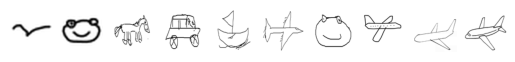

In [31]:
import os
import numpy as np
from tensorflow.keras.models import load_model


np.set_printoptions(precision=3, suppress=True)
i=0
for file_name in os.listdir('/content/drive/MyDrive/resimler'):
    if file_name.endswith('.png'):
        img_path = '/content/drive/MyDrive/resimler/' + file_name

        # Resmi yükle ve boyutlandır
        img = Image.open(img_path).convert('L')
        img = img.resize((img_size), resample=Image.LANCZOS)
        # Resmi model için hazırla
        x = img_to_array(img)
         # Subplot'lara resimleri çizdir
        axs = plt.subplot(1, 10, i+1)
        axs.imshow(x, cmap='gray')
        axs.axis('off')
        i+=1
        x = x.reshape((1,) + x.shape)
        #x/=255.0
        # Tahmin yap ve sonucu yazdır;
        prediction = best_model.predict(x)
        print(prediction)
        predicted_class = np.argmax(prediction)
        print('Resim:', file_name, 'Tahmin:', predicted_class)
        
        

plt.show()